<h2>1. Collecting Data

In [ ]:
import os
import cv2
import time
#import shutil # Uncomment if you want to enable deleting partial sequences on abort

# --- Configuration ---
DATA_DIR = './data_alphabet_sequences' # Store sequences in a new directory
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Define the classes you want to collect
# classes = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
#            'N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
#            'Hello','My','Engineer','Name','Yes','No','Me'] 
NUM_SEQUENCES_PER_CLASS = 10  # How many sequences (examples) to collect for each class
SEQUENCE_LENGTH = 10          # Total frames to capture per sequence
CAPTURE_DURATION = 0.6        # Total duration to capture sequence in seconds (0.6s for comfortable signing)
# Ensure delay is at least 1ms
CAPTURE_DELAY_MS = max(1, int((CAPTURE_DURATION * 1000) / SEQUENCE_LENGTH))  # Calculate delay between frames
WINDOW_NAME = 'Data Collection' # Define window name

print(f"Configuration:")
print(f" - Classes: {classes}")
print(f" - Sequences per class: {NUM_SEQUENCES_PER_CLASS}")
print(f" - Frames per sequence: {SEQUENCE_LENGTH}")
print(f" - Target capture duration: {CAPTURE_DURATION} seconds")
print(f" - Calculated delay between frames: {CAPTURE_DELAY_MS} ms")
print("-" * 20)

# --- Main Collection Logic ---
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Optional: Set resolution if needed
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

print("Controls:")
print("  S: Start recording sequence for the current class")
print("  Q: Quit collecting for the current class (move to next)")
print("  Esc: Exit the program entirely")
print("-" * 20)

exit_program = False # Flag to signal exiting the entire script

for sign_class in classes:
    if exit_program: # Check if we need to exit before starting next class
        break

    class_path = os.path.join(DATA_DIR, sign_class)
    if not os.path.exists(class_path):
        os.makedirs(class_path)

    print(f'\nCollecting data for class: {sign_class}')

    # Find the highest sequence number in existing folders to continue from there
    existing_sequences = []
    if os.path.exists(class_path):
        for item in os.listdir(class_path):
            # Check if item is a directory and its name is a number
            if os.path.isdir(os.path.join(class_path, item)) and item.isdigit():
                try: # Add try-except for robustness
                    existing_sequences.append(int(item))
                except ValueError:
                    pass # Ignore non-numeric folders

    # Determine starting sequence number
    starting_sequence_num = max(existing_sequences) + 1 if existing_sequences else 0
    target_sequence_count = starting_sequence_num + NUM_SEQUENCES_PER_CLASS

    print(f" - Starting from sequence number: {starting_sequence_num}")
    print(f" - Will collect {NUM_SEQUENCES_PER_CLASS} new sequences (up to sequence {target_sequence_count - 1})")

    sequence_counter = starting_sequence_num

    # Loop for collecting sequences for the current class
    while sequence_counter < target_sequence_count:
        # Display instructions and wait for trigger
        instruction_text = f"Class: {sign_class} | Next Seq: {sequence_counter} | Press 'S' | 'Q' Quit Class | 'Esc' Exit"
        recording_active = False

        while True: # Inner loop: Wait for user action (S, Q, or Esc)
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture frame.")
                time.sleep(0.1)
                continue

            # Display instructions on the frame
            cv2.putText(frame, instruction_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.putText(frame, f"Target: {SEQUENCE_LENGTH} frames in {CAPTURE_DURATION}s",
                       (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2, cv2.LINE_AA)

            cv2.imshow(WINDOW_NAME, frame)

            key = cv2.waitKey(30) & 0xFF  # More responsive wait while idle

            if key == 27: # ESC key pressed
                print("Escape key pressed. Exiting program.")
                exit_program = True
                break # Exit inner loop

            if key == ord('q'):
                print(f"Quitting collection for class {sign_class}.")
                sequence_counter = target_sequence_count # Force exit outer loop for this class
                break # Exit the inner waiting loop

            if key == ord('s'):
                recording_active = True
                break # Exit the inner waiting loop to start recording

        # Check if we need to exit the program or the class loop
        if exit_program:
            break
        # This handles quitting the class with 'Q' or finishing all sequences
        if sequence_counter >= target_sequence_count and not recording_active:
             break

        # Start recording the sequence if triggered
        if recording_active:
            print(f"  Starting sequence {sequence_counter}...")
            sequence_path = os.path.join(class_path, f"{sequence_counter:03d}") # Padded sequence number
            os.makedirs(sequence_path, exist_ok=True)

            # --- Modified Countdown ---
            # Display "GET READY!" and wait 0.5 seconds before starting capture
            print("  Get Ready...") # Console message
            ret, frame = cap.read()
            if ret:
                cv2.putText(frame, "GET READY!", (frame.shape[1]//4, frame.shape[0]//2),
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3, cv2.LINE_AA)
                cv2.imshow(WINDOW_NAME, frame)
                cv2.waitKey(500) # Wait 0.5 seconds
            # --- End Modified Countdown ---


            # --- Frame capture loop for the sequence ---
            sequence_aborted = False
            # start_time = time.time() # Keep if you want to display elapsed time

            for frame_num in range(SEQUENCE_LENGTH):
                ret, frame = cap.read()
                if not ret:
                    print(f"Error: Failed to capture frame during sequence {sequence_counter}, frame {frame_num}.")
                    sequence_aborted = True
                    break # Exit frame capture loop

                # --- Display recording status (Optional but helpful) ---
                # elapsed = time.time() - start_time
                # cv2.putText(frame, f"REC Seq {sequence_counter} Frame {frame_num+1}/{SEQUENCE_LENGTH}",
                #            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)
                # cv2.putText(frame, f"Time: {elapsed:.2f}s / {CAPTURE_DURATION}s",
                #            (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv2.LINE_AA)

                # --- Show progress bar ---
                progress_width = int(((frame_num + 1) / SEQUENCE_LENGTH) * frame.shape[1] * 0.8) # Use frame_num+1 for progress
                cv2.rectangle(frame, (int(frame.shape[1]*0.1), frame.shape[0]-30),
                             (int(frame.shape[1]*0.1) + progress_width, frame.shape[0]-20), (0, 255, 0), -1)

                cv2.imshow(WINDOW_NAME, frame)

                # --- Save the frame ---
                frame_filename = os.path.join(sequence_path, f"{frame_num:03d}.jpg") # Padded frame number
                cv2.imwrite(frame_filename, frame) # This still takes time! Consider deferring if timing is critical

                # --- Wait and check for abort keys ---
                key_capture = cv2.waitKey(CAPTURE_DELAY_MS) & 0xFF

                if key_capture == ord('q'):
                    print("Warning: Sequence recording aborted by user (Q pressed).")
                    sequence_aborted = True
                    # Consider deleting the partially recorded sequence folder here if desired
                    # import shutil
                    # if os.path.exists(sequence_path): shutil.rmtree(sequence_path)
                    sequence_counter = target_sequence_count # Force quit class
                    break
                elif key_capture == 27: # ESC key pressed
                     print("Warning: Sequence recording aborted by user (Esc pressed). Exiting program.")
                     sequence_aborted = True
                     # Consider deleting the partially recorded sequence folder here if desired
                     # import shutil
                     # if os.path.exists(sequence_path): shutil.rmtree(sequence_path)
                     exit_program = True # Signal exit for outer loops
                     break
            # --- End Frame Capture Loop ---


            # --- Post-Capture Actions ---
            if exit_program: # Check if user pressed Esc mid-sequence
                 print(f"  Sequence {sequence_counter} aborted due to exit request.")
                 break # Exit class loop

            if not sequence_aborted:
                print(f"  Finished sequence {sequence_counter}. Saved {SEQUENCE_LENGTH} frames in {sequence_path}")
                # --- !!! Increment the counter !!! ---
                sequence_counter += 1
                # --- Add a small pause before the next prompt ---
                time.sleep(0.5)
            else:
                # Handle sequence aborted by 'q' (message already printed)
                # sequence_counter is already set to target_sequence_count to exit class loop
                 print(f"  Sequence {sequence_counter} aborted by user ('Q').")
                 pass # Continue to next iteration of class loop (which will exit)


    # End of sequence collection loop for one class
    if exit_program: # Check if we need to exit after finishing/quitting a class
        break

# --- Cleanup ---
print("\nData collection finished or exited.")
if cap.isOpened(): cap.release() # Ensure release happens
print("Webcam released.")

# Explicitly destroy the named window
print("Attempting to close OpenCV window...")
for i in range(5): # Loop helps ensure window closes on some systems
    cv2.destroyWindow(WINDOW_NAME)
    cv2.waitKey(1)

# Fallback for any other windows
cv2.destroyAllWindows()
for i in range(5): cv2.waitKey(1) # Help process closing events

print("OpenCV windows closed.")
print("Resources released.")


Configuration:
 - Classes: ['Z']
 - Sequences per class: 10
 - Frames per sequence: 20
 - Target capture duration: 0.6 seconds
 - Calculated delay between frames: 30 ms
--------------------
Controls:
  S: Start recording sequence for the current class
  Q: Quit collecting for the current class (move to next)
  Esc: Exit the program entirely
--------------------

 - Starting from sequence number: 0
 - Will collect 10 new sequences (up to sequence 9)
  Starting sequence 0...
  Get Ready...
  Finished sequence 0. Saved 20 frames in ./data_alphabet_sequences/Z/000
  Starting sequence 1...
  Get Ready...
  Finished sequence 1. Saved 20 frames in ./data_alphabet_sequences/Z/001
  Starting sequence 2...
  Get Ready...
  Finished sequence 2. Saved 20 frames in ./data_alphabet_sequences/Z/002
  Starting sequence 3...
  Get Ready...
  Finished sequence 3. Saved 20 frames in ./data_alphabet_sequences/Z/003
  Starting sequence 4...
  Get Ready...
  Finished sequence 4. Saved 20 frames in ./data_al

<h2>2. Create dataset

In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pickle
from tqdm import tqdm # For progress bar

# --- Configuration ---
DATA_DIR = './data_alphabet_sequences' # Directory where sequence folders are stored
OUTPUT_PICKLE_FILE = './train_data_set/asl_sequences_dataset.pickle' # Output file path
SEQUENCE_LENGTH = 10          # Must match the collection script (e.g., 30 frames)
NUM_LANDMARKS = 21            # Number of landmarks per hand
FEATURES_PER_LANDMARK = 2     # Using x, y coordinates
FEATURES_PER_HAND = NUM_LANDMARKS * FEATURES_PER_LANDMARK # Should be 42
TARGET_FEATURES_PER_FRAME = FEATURES_PER_HAND * 2         # Target 84 features (for two hands)

# Define the classes you want to process (start with 5 for testing)
# Make sure these match folder names in DATA_DIR
# classes_to_process = ['A', 'B', 'C', 'D', 'E']
# Or use the full list if data exists:
#classes_to_process = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','Hello','Me','Yes','No','Help','Please','Thank_You','Want','What','Again','Eat','More','Go_to','Fine','Like','Learn','Finish','Name','How','You','Nice','Meet']
classes_to_process = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
           'N','O','P','Q','R','S','T','U','V','W','X','Y','Z'
           'Hello','My','Engineer','Name','Yes','No','Me']
# --- MediaPipe Initialization ---
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,       # Process video frames
    max_num_hands=2,               # Detect up to two hands
    min_detection_confidence=0.5,  # Adjust as needed
    min_tracking_confidence=0.5
)

# --- Helper Functions ---

def normalize_landmarks(landmarks, image_shape):
    """
    Normalizes landmarks relative to the hand's bounding box.
    Returns a list of 42 features or None if normalization fails.
    """
    if not landmarks:
        return None

    x_coords = [lm.x * image_shape[1] for lm in landmarks.landmark] # Convert to pixel coords
    y_coords = [lm.y * image_shape[0] for lm in landmarks.landmark]

    if not x_coords or not y_coords:
        return None

    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # Avoid division by zero for degenerate bounding boxes
    if x_max == x_min or y_max == y_min:
        # print("Warning: Degenerate bounding box detected.")
        return None # Indicate failure

    normalized_features = []
    for lm in landmarks.landmark:
        # Normalize relative to the bounding box
        norm_x = (lm.x * image_shape[1] - x_min) / (x_max - x_min)
        norm_y = (lm.y * image_shape[0] - y_min) / (y_max - y_min)
        normalized_features.extend([norm_x, norm_y])

    if len(normalized_features) != FEATURES_PER_HAND:
        print(f"Warning: Incorrect feature count after normalization: {len(normalized_features)}")
        return None

    return normalized_features

def mirror_features(features_42):
    """Mirrors a 42-feature vector horizontally."""
    if features_42 is None or len(features_42) != FEATURES_PER_HAND:
        return None # Or return zeros? Let's return None for clarity

    mirrored = []
    for i in range(0, FEATURES_PER_HAND, 2): # Step through x, y pairs
        norm_x = features_42[i]
        norm_y = features_42[i+1]
        mirrored_norm_x = 1.0 - norm_x # Flip normalized x
        mirrored.extend([mirrored_norm_x, norm_y])
    return mirrored

# --- Main Processing Logic ---

all_sequences_data = []
all_sequences_labels = []
processed_sequences_count = 0
skipped_sequences_count = 0

print(f"Processing sequences from: {DATA_DIR}")
print(f"Target classes: {classes_to_process}")
print(f"Sequence Length: {SEQUENCE_LENGTH}")
print(f"Target Features per Frame: {TARGET_FEATURES_PER_FRAME}")
print("-" * 30)

# Iterate through specified class directories
for sign_class in classes_to_process:
    class_path = os.path.join(DATA_DIR, sign_class)
    print(f"\nProcessing Class: {sign_class}...")

    if not os.path.isdir(class_path):
        print(f"  Warning: Directory not found for class '{sign_class}'. Skipping.")
        continue

    # Iterate through sequence folders (e.g., '000', '001', ...)
    sequence_folders = sorted([f for f in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, f)) and f.isdigit()])

    if not sequence_folders:
        print(f"  No sequence folders found in {class_path}. Skipping class.")
        continue

    print(f"  Found {len(sequence_folders)} sequence folders.")

    for seq_folder_name in tqdm(sequence_folders, desc=f"  Sequences for {sign_class}", unit="seq"):
        seq_path = os.path.join(class_path, seq_folder_name)
        sequence_frame_features = [] # Store features for all frames in this sequence

        frame_files = sorted([f for f in os.listdir(seq_path) if f.lower().endswith('.jpg') or f.lower().endswith('.png')])

        # Ensure frames are processed in order (000.jpg, 001.jpg, ...)
        frame_files.sort(key=lambda x: int(os.path.splitext(x)[0]))

        if len(frame_files) != SEQUENCE_LENGTH:
             print(f"\n  Warning: Sequence {seq_folder_name} in class {sign_class} has {len(frame_files)} frames, expected {SEQUENCE_LENGTH}. Skipping.")
             skipped_sequences_count += 1
             continue # Skip this sequence if frame count is wrong

        valid_sequence = True
        for frame_filename in frame_files:
            frame_path = os.path.join(seq_path, frame_filename)
            frame = cv2.imread(frame_path)

            if frame is None:
                print(f"\n  Warning: Failed to read frame {frame_path}. Skipping sequence {seq_folder_name}.")
                valid_sequence = False
                break # Skip rest of the frames in this sequence

            # Process frame with MediaPipe
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image_rgb.flags.writeable = False # Optimize
            results = hands.process(image_rgb)
            image_rgb.flags.writeable = True

            # Initialize frame features with zeros (padding)
            frame_features = np.zeros(TARGET_FEATURES_PER_FRAME, dtype=np.float32)
            normalized_hands = [] # Store normalized features for detected hands

            if results.multi_hand_landmarks:
                # Normalize landmarks for each detected hand
                for hand_landmarks in results.multi_hand_landmarks:
                    norm_features = normalize_landmarks(hand_landmarks, frame.shape)
                    if norm_features:
                        normalized_hands.append(norm_features)

                # Sort hands by horizontal position (leftmost first) - Optional but good practice
                # This requires getting a representative point like the wrist (landmark 0)
                # For simplicity now, just take first two detected if more than 2
                normalized_hands = normalized_hands[:2] # Max 2 hands

                # Assign features based on number of hands detected
                if len(normalized_hands) == 1:
                    # Place the single hand in the first 42 slots
                    frame_features[:FEATURES_PER_HAND] = normalized_hands[0]
                elif len(normalized_hands) == 2:
                    # Decide order (e.g., based on x-coord of wrist)
                    # For now, just assign first detected to first slot, second to second
                    frame_features[:FEATURES_PER_HAND] = normalized_hands[0]
                    frame_features[FEATURES_PER_HAND:] = normalized_hands[1]

            # Append the (potentially padded) 84 features for this frame
            sequence_frame_features.append(frame_features)

        # After processing all frames for the sequence
        if valid_sequence and len(sequence_frame_features) == SEQUENCE_LENGTH:
            processed_sequences_count += 1

            # 1. Add the original sequence
            all_sequences_data.append(sequence_frame_features)
            all_sequences_labels.append(sign_class)

            # 2. Create and add the mirrored sequence
            mirrored_sequence = []
            for frame_vec_84 in sequence_frame_features:
                # Separate the 84 features into two potential hands
                hand1_original = frame_vec_84[:FEATURES_PER_HAND]
                hand2_original = frame_vec_84[FEATURES_PER_HAND:]

                # Mirror each part (mirroring zeros is harmless)
                hand1_mirrored = mirror_features(hand1_original.tolist()) # Convert np array slice to list
                hand2_mirrored = mirror_features(hand2_original.tolist())

                # Handle potential None from mirroring failure (though unlikely with zeros)
                if hand1_mirrored is None: hand1_mirrored = np.zeros(FEATURES_PER_HAND, dtype=np.float32)
                if hand2_mirrored is None: hand2_mirrored = np.zeros(FEATURES_PER_HAND, dtype=np.float32)

                # Combine mirrored parts
                mirrored_frame_vec_84 = np.concatenate([hand1_mirrored, hand2_mirrored]).astype(np.float32)
                mirrored_sequence.append(mirrored_frame_vec_84)

            # Add the complete mirrored sequence
            all_sequences_data.append(mirrored_sequence)
            all_sequences_labels.append(sign_class) # Same label for mirrored version

        elif not valid_sequence:
             skipped_sequences_count += 1
        # else: sequence length was wrong (already handled)


# --- Final Steps ---
hands.close() # Release MediaPipe resources

print("\n" + "-" * 30)
print("Processing Summary:")
print(f"  Total sequences processed (before mirroring): {processed_sequences_count}")
print(f"  Total sequences skipped (frame errors/count mismatch): {skipped_sequences_count}")
print(f"  Total samples generated (including mirrored): {len(all_sequences_data)}")
print(f"  Total labels generated: {len(all_sequences_labels)}")

if not all_sequences_data:
    print("\nError: No valid sequences were processed. Cannot save dataset.")
else:
    # Convert to NumPy arrays
    # Ensure all sequences are numpy arrays of the correct shape
    try:
        data_array = np.array(all_sequences_data, dtype=np.float32)
        label_array = np.array(all_sequences_labels)

        print(f"\nFinal data array shape: {data_array.shape}") # Should be (num_samples, SEQUENCE_LENGTH, TARGET_FEATURES_PER_FRAME)
        print(f"Final label array shape: {label_array.shape}")

        # Shuffle the data
        indices = np.random.permutation(len(data_array))
        shuffled_data = data_array[indices]
        shuffled_labels = label_array[indices]

        # Create output directory if needed
        output_dir = os.path.dirname(OUTPUT_PICKLE_FILE)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save the dataset
        print(f"\nSaving shuffled dataset to: {OUTPUT_PICKLE_FILE}")
        try:
            with open(OUTPUT_PICKLE_FILE, 'wb') as f:
                # Saving as dictionary for clarity, converting arrays to lists for pickle compatibility if needed
                # Using np.save might be more efficient for large arrays, but pickle is common
                pickle.dump({'data': shuffled_data.tolist(), 'labels': shuffled_labels.tolist()}, f)
            print("Dataset saved successfully.")
        except Exception as e:
            print(f"Error saving pickle file: {e}")

    except ValueError as e:
        print(f"\nError creating final NumPy array. This might be due to inconsistent sequence lengths or feature vector sizes: {e}")
        print("Please check warnings during processing.")
    except Exception as e:
        print(f"\nAn unexpected error occurred during final processing: {e}")

print("\nDataset creation script finished.")
# ```
#

I0000 00:00:1746305788.224182 26907441 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro


Processing sequences from: ./data_alphabet_sequences
Target classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Hello', 'My', 'Engineer', 'Name', 'Yes', 'No', 'Me']
Sequence Length: 10
Target Features per Frame: 84
------------------------------

Processing Class: A...
  Found 10 sequence folders.


  Sequences for A:   0%|          | 0/10 [00:00<?, ?seq/s]W0000 00:00:1746305788.231767 27770811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746305788.236452 27770812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
  Sequences for A: 100%|██████████| 10/10 [00:02<00:00,  4.05seq/s]



Processing Class: B...
  Found 10 sequence folders.


  Sequences for B: 100%|██████████| 10/10 [00:02<00:00,  4.18seq/s]



Processing Class: C...
  Found 10 sequence folders.


  Sequences for C: 100%|██████████| 10/10 [00:02<00:00,  4.21seq/s]



Processing Class: D...
  Found 10 sequence folders.


  Sequences for D: 100%|██████████| 10/10 [00:02<00:00,  4.19seq/s]



Processing Class: E...
  Found 10 sequence folders.


  Sequences for E: 100%|██████████| 10/10 [00:02<00:00,  4.16seq/s]



Processing Class: F...
  Found 10 sequence folders.


  Sequences for F: 100%|██████████| 10/10 [00:02<00:00,  4.06seq/s]



Processing Class: G...
  Found 10 sequence folders.


  Sequences for G: 100%|██████████| 10/10 [00:02<00:00,  4.08seq/s]



Processing Class: H...
  Found 10 sequence folders.


  Sequences for H: 100%|██████████| 10/10 [00:02<00:00,  4.06seq/s]



Processing Class: I...
  Found 10 sequence folders.


  Sequences for I: 100%|██████████| 10/10 [00:02<00:00,  3.98seq/s]



Processing Class: J...
  Found 10 sequence folders.


  Sequences for J: 100%|██████████| 10/10 [00:02<00:00,  4.05seq/s]



Processing Class: K...
  Found 10 sequence folders.


  Sequences for K: 100%|██████████| 10/10 [00:02<00:00,  3.94seq/s]



Processing Class: L...
  Found 10 sequence folders.


  Sequences for L: 100%|██████████| 10/10 [00:02<00:00,  4.04seq/s]



Processing Class: M...
  Found 10 sequence folders.


  Sequences for M: 100%|██████████| 10/10 [00:02<00:00,  4.01seq/s]



Processing Class: N...
  Found 10 sequence folders.


  Sequences for N: 100%|██████████| 10/10 [00:02<00:00,  3.93seq/s]



Processing Class: O...
  Found 10 sequence folders.


  Sequences for O: 100%|██████████| 10/10 [00:02<00:00,  4.04seq/s]



Processing Class: P...
  Found 10 sequence folders.


  Sequences for P: 100%|██████████| 10/10 [00:02<00:00,  3.96seq/s]



Processing Class: Q...
  Found 10 sequence folders.


  Sequences for Q: 100%|██████████| 10/10 [00:02<00:00,  3.99seq/s]



Processing Class: R...
  Found 10 sequence folders.


  Sequences for R: 100%|██████████| 10/10 [00:02<00:00,  3.95seq/s]



Processing Class: S...
  Found 10 sequence folders.


  Sequences for S: 100%|██████████| 10/10 [00:02<00:00,  3.88seq/s]



Processing Class: T...
  Found 10 sequence folders.


  Sequences for T: 100%|██████████| 10/10 [00:02<00:00,  3.81seq/s]



Processing Class: U...
  Found 10 sequence folders.


  Sequences for U: 100%|██████████| 10/10 [00:02<00:00,  3.96seq/s]



Processing Class: V...
  Found 10 sequence folders.


  Sequences for V: 100%|██████████| 10/10 [00:02<00:00,  3.94seq/s]



Processing Class: W...
  Found 10 sequence folders.


  Sequences for W: 100%|██████████| 10/10 [00:02<00:00,  3.92seq/s]



Processing Class: X...
  Found 10 sequence folders.


  Sequences for X: 100%|██████████| 10/10 [00:02<00:00,  3.97seq/s]



Processing Class: Y...
  Found 10 sequence folders.


  Sequences for Y: 100%|██████████| 10/10 [00:02<00:00,  3.97seq/s]



Processing Class: Z...
  Found 10 sequence folders.


  Sequences for Z: 100%|██████████| 10/10 [00:02<00:00,  3.65seq/s]



Processing Class: Hello...
  Found 10 sequence folders.


  Sequences for Hello: 100%|██████████| 10/10 [00:02<00:00,  3.81seq/s]



Processing Class: My...
  Found 10 sequence folders.


  Sequences for My: 100%|██████████| 10/10 [00:02<00:00,  3.88seq/s]



Processing Class: Engineer...
  Found 10 sequence folders.


  Sequences for Engineer: 100%|██████████| 10/10 [00:02<00:00,  4.22seq/s]



Processing Class: Name...
  Found 10 sequence folders.


  Sequences for Name: 100%|██████████| 10/10 [00:02<00:00,  4.00seq/s]



Processing Class: Yes...
  Found 10 sequence folders.


  Sequences for Yes: 100%|██████████| 10/10 [00:02<00:00,  3.78seq/s]



Processing Class: No...
  Found 10 sequence folders.


  Sequences for No: 100%|██████████| 10/10 [00:02<00:00,  3.88seq/s]



Processing Class: Me...
  Found 10 sequence folders.


  Sequences for Me: 100%|██████████| 10/10 [00:02<00:00,  3.75seq/s]


------------------------------
Processing Summary:
  Total sequences processed (before mirroring): 330
  Total sequences skipped (frame errors/count mismatch): 0
  Total samples generated (including mirrored): 660
  Total labels generated: 660

Final data array shape: (660, 10, 84)
Final label array shape: (660,)

Saving shuffled dataset to: ./train_data_set/asl_sequences_dataset.pickle
Dataset saved successfully.

Dataset creation script finished.


Try Create DataSet with Z Dimension

In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pickle
from tqdm import tqdm # For progress bar
import traceback # For detailed error logging

# --- Configuration ---
DATA_DIR = './data_alphabet_sequences' # Directory where sequence folders are stored
OUTPUT_PICKLE_FILE = './train_data_set/asl_sequences_dataset_3D.pickle' # Output file path
SEQUENCE_LENGTH = 10          # Fixed sequence length as requested
NUM_LANDMARKS = 21            # Number of landmarks per hand (MediaPipe default)
USE_Z_COORDINATE = True      # Set to True to include Z coordinate (depth)

# Calculate features based on configuration
FEATURES_PER_LANDMARK = 3 if USE_Z_COORDINATE else 2
FEATURES_PER_HAND = NUM_LANDMARKS * FEATURES_PER_LANDMARK # 63 if Z used, 42 otherwise
TARGET_FEATURES_PER_FRAME = FEATURES_PER_HAND * 2         # Total features for two hands (126 or 84)

# Define the classes you want to process
# Make sure these match folder names in DATA_DIR
classes_to_process = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
                      'N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                      'Hello','My','Engineer','Name','Yes','No','Me']
# --- MediaPipe Initialization ---
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,       # Process video frames
    max_num_hands=2,               # Detect up to two hands
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
mp_drawing = mp.solutions.drawing_utils # For visualization (optional)

# --- Helper Functions ---

def normalize_landmarks(landmarks, image_shape):
    """
    Normalizes landmarks relative to the hand's bounding box.
    Includes Z coordinate if USE_Z_COORDINATE is True.
    Returns a list of features (42 or 63) or None if normalization fails.
    """
    if not landmarks:
        return None

    # Extract coordinates into lists
    x_coords_px = [lm.x * image_shape[1] for lm in landmarks.landmark] # Pixel coords
    y_coords_px = [lm.y * image_shape[0] for lm in landmarks.landmark]
    # Z coordinate from MediaPipe is relative depth to wrist, usually needs less normalization
    z_coords = [lm.z for lm in landmarks.landmark]

    if not x_coords_px or not y_coords_px: # Should not happen if landmarks exist, but check
        return None

    # Calculate bounding box
    x_min, x_max = min(x_coords_px), max(x_coords_px)
    y_min, y_max = min(y_coords_px), max(y_coords_px)

    # Avoid division by zero for degenerate bounding boxes (e.g., hand at edge)
    width = x_max - x_min
    height = y_max - y_min
    if width == 0 or height == 0:
        # print(f"Warning: Degenerate bounding box detected (width={width}, height={height}). Skipping normalization for this hand.")
        # Return zeros or None? Returning None indicates failure for this hand.
        return None

    # Normalize x, y relative to the bounding box
    normalized_features = []
    for i, lm in enumerate(landmarks.landmark):
        norm_x = (x_coords_px[i] - x_min) / width
        norm_y = (y_coords_px[i] - y_min) / height
        normalized_features.extend([norm_x, norm_y])
        if USE_Z_COORDINATE:
            # Z is often used directly or normalized differently (e.g., scaling)
            # Here, we'll just include it as is for simplicity.
            # Consider scaling z_coords relative to wrist z if needed later.
            normalized_features.append(z_coords[i])

    # Final check on feature count
    if len(normalized_features) != FEATURES_PER_HAND:
        print(f"Warning: Incorrect feature count after normalization: {len(normalized_features)}, expected {FEATURES_PER_HAND}.")
        return None

    return normalized_features

def mirror_features(features_hand):
    """
    Mirrors a single hand's feature vector horizontally.
    Handles both 2D (42 features) and 3D (63 features).
    """
    if features_hand is None or len(features_hand) != FEATURES_PER_HAND:
        # Return zeros of the correct dimension if input is invalid/padded
        return np.zeros(FEATURES_PER_HAND, dtype=np.float32).tolist()

    mirrored = []
    step = FEATURES_PER_LANDMARK # 2 for XY, 3 for XYZ
    for i in range(0, FEATURES_PER_HAND, step):
        norm_x = features_hand[i]
        mirrored_norm_x = 1.0 - norm_x # Flip normalized x
        mirrored.append(mirrored_norm_x)
        mirrored.append(features_hand[i+1]) # Keep y
        if USE_Z_COORDINATE:
            mirrored.append(features_hand[i+2]) # Keep z

    return mirrored

# --- Main Processing Logic ---

all_sequences_data = []
all_sequences_labels = []
processed_sequences_count = 0
skipped_sequences_count = 0
skipped_sequences_details = {} # Store reasons for skipping

print("--- Dataset Creation Configuration ---")
print(f"Data Source Directory: {DATA_DIR}")
print(f"Output Pickle File: {OUTPUT_PICKLE_FILE}")
print(f"Target Sequence Length: {SEQUENCE_LENGTH}")
print(f"Include Z Coordinate: {USE_Z_COORDINATE}")
print(f"Features per Landmark: {FEATURES_PER_LANDMARK}")
print(f"Features per Hand: {FEATURES_PER_HAND}")
print(f"Target Features per Frame (2 Hands): {TARGET_FEATURES_PER_FRAME}")
print(f"Classes to Process: {classes_to_process}")
print("-" * 40)

# Iterate through specified class directories
for sign_class in classes_to_process:
    class_path = os.path.join(DATA_DIR, sign_class)
    print(f"\nProcessing Class: {sign_class}...")

    if not os.path.isdir(class_path):
        print(f"  Warning: Directory not found for class '{sign_class}'. Skipping.")
        continue

    # Iterate through sequence folders (e.g., '000', '001', ...)
    sequence_folders = sorted([f for f in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, f)) and f.isdigit()])

    if not sequence_folders:
        print(f"  No sequence folders found in {class_path}. Skipping class.")
        continue

    print(f"  Found {len(sequence_folders)} sequence folders.")

    for seq_folder_name in tqdm(sequence_folders, desc=f"  Sequences for {sign_class}", unit="seq", leave=False):
        seq_path = os.path.join(class_path, seq_folder_name)
        sequence_frame_features = [] # Store features for all frames in this sequence
        sequence_skipped = False
        skip_reason = ""

        frame_files = sorted([f for f in os.listdir(seq_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])

        # Ensure frames are processed in numeric order
        try:
            frame_files.sort(key=lambda x: int(os.path.splitext(x)[0]))
        except ValueError:
            print(f"\n  Warning: Non-numeric frame filenames found in {seq_path}. Skipping sequence.")
            sequence_skipped = True
            skip_reason = "Non-numeric filenames"

        if not sequence_skipped and len(frame_files) != SEQUENCE_LENGTH:
             # print(f"\n  Warning: Sequence {seq_folder_name} in class {sign_class} has {len(frame_files)} frames, expected {SEQUENCE_LENGTH}. Skipping.")
             sequence_skipped = True
             skip_reason = f"Incorrect frame count ({len(frame_files)} vs {SEQUENCE_LENGTH})"
             # Continue processing frames below, but mark sequence as skipped

        if sequence_skipped:
            skipped_sequences_count += 1
            if sign_class not in skipped_sequences_details: skipped_sequences_details[sign_class] = {}
            if skip_reason not in skipped_sequences_details[sign_class]: skipped_sequences_details[sign_class][skip_reason] = 0
            skipped_sequences_details[sign_class][skip_reason] += 1
            continue # Skip to the next sequence folder


        # Process frames if count is correct
        valid_sequence_frames = True
        for frame_filename in frame_files:
            frame_path = os.path.join(seq_path, frame_filename)
            frame = cv2.imread(frame_path)

            if frame is None:
                print(f"\n  Warning: Failed to read frame {frame_path}. Skipping sequence {seq_folder_name}.")
                valid_sequence_frames = False
                skip_reason = f"Failed to read frame {frame_filename}"
                break # Skip rest of the frames in this sequence

            # Process frame with MediaPipe
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image_rgb.flags.writeable = False # Optimize
            results = hands.process(image_rgb)
            image_rgb.flags.writeable = True

            # Initialize frame features with zeros (padding)
            frame_features = np.zeros(TARGET_FEATURES_PER_FRAME, dtype=np.float32)
            detected_hands_data = [] # Store tuples of (wrist_x, normalized_features)

            if results.multi_hand_landmarks:
                # Normalize landmarks for each detected hand
                for hand_landmarks in results.multi_hand_landmarks:
                    norm_features = normalize_landmarks(hand_landmarks, frame.shape)
                    if norm_features:
                        # Get wrist x-coordinate (landmark 0, x is the first feature) for sorting
                        wrist_x = hand_landmarks.landmark[0].x
                        detected_hands_data.append((wrist_x, norm_features))

                # Sort hands by horizontal position (leftmost first)
                detected_hands_data.sort(key=lambda item: item[0]) # Sort based on wrist_x

                # Assign features based on sorted order (up to 2 hands)
                num_hands_to_assign = min(len(detected_hands_data), 2)
                for i in range(num_hands_to_assign):
                    hand_features = detected_hands_data[i][1] # Get the normalized features
                    start_index = i * FEATURES_PER_HAND
                    end_index = start_index + FEATURES_PER_HAND
                    frame_features[start_index:end_index] = hand_features

            # Append the (potentially padded) features for this frame
            sequence_frame_features.append(frame_features)

        # After processing all frames for the sequence
        if not valid_sequence_frames:
             skipped_sequences_count += 1
             if sign_class not in skipped_sequences_details: skipped_sequences_details[sign_class] = {}
             if skip_reason not in skipped_sequences_details[sign_class]: skipped_sequences_details[sign_class][skip_reason] = 0
             skipped_sequences_details[sign_class][skip_reason] += 1
             continue # Skip this sequence

        # If we reached here, the sequence has the correct length and all frames were read
        if len(sequence_frame_features) == SEQUENCE_LENGTH:
            processed_sequences_count += 1

            # 1. Add the original sequence
            all_sequences_data.append(sequence_frame_features)
            all_sequences_labels.append(sign_class)

            # 2. Create and add the mirrored sequence
            mirrored_sequence = []
            for frame_vec in sequence_frame_features:
                # Separate the features into two potential hands
                # frame_vec is already a numpy array here
                hand1_original = frame_vec[:FEATURES_PER_HAND].tolist() # Convert slice to list for mirror func
                hand2_original = frame_vec[FEATURES_PER_HAND:].tolist()

                # Mirror each part
                hand1_mirrored = mirror_features(hand1_original)
                hand2_mirrored = mirror_features(hand2_original)

                # Combine mirrored parts. IMPORTANT: Maintain the sorted order logic.
                # The hand that was originally on the left (hand1) becomes the mirrored right hand.
                # The hand that was originally on the right (hand2) becomes the mirrored left hand.
                # So, the mirrored features for hand2 should come first in the mirrored vector.
                mirrored_frame_vec = np.concatenate([hand2_mirrored, hand1_mirrored]).astype(np.float32)
                mirrored_sequence.append(mirrored_frame_vec)

            # Add the complete mirrored sequence
            all_sequences_data.append(mirrored_sequence)
            all_sequences_labels.append(sign_class) # Same label

        else:
            # This case should ideally not be reached due to checks above, but as a safeguard:
            print(f"\n  Internal Warning: Sequence {seq_folder_name} ({sign_class}) ended with {len(sequence_frame_features)} frames processed, expected {SEQUENCE_LENGTH}. Skipping.")
            skipped_sequences_count += 1
            skip_reason = "Post-processing frame count mismatch"
            if sign_class not in skipped_sequences_details: skipped_sequences_details[sign_class] = {}
            if skip_reason not in skipped_sequences_details[sign_class]: skipped_sequences_details[sign_class][skip_reason] = 0
            skipped_sequences_details[sign_class][skip_reason] += 1


# --- Final Steps ---
hands.close() # Release MediaPipe resources

print("\n" + "-" * 40)
print("Processing Summary:")
print(f"  Total sequences processed (before mirroring): {processed_sequences_count}")
print(f"  Total sequences skipped: {skipped_sequences_count}")
if skipped_sequences_count > 0:
    print("  Skipped sequence details (Class -> Reason -> Count):")
    for class_name, reasons in skipped_sequences_details.items():
        print(f"    {class_name}:")
        for reason, count in reasons.items():
            print(f"      - {reason}: {count}")
print(f"  Total samples generated (including mirrored): {len(all_sequences_data)}")
print(f"  Total labels generated: {len(all_sequences_labels)}")
print("-" * 40)

if not all_sequences_data:
    print("\nError: No valid sequences were processed. Cannot save dataset.")
else:
    # Convert to NumPy arrays
    try:
        data_array = np.array(all_sequences_data, dtype=np.float32)
        label_array = np.array(all_sequences_labels)

        print(f"\nFinal data array shape: {data_array.shape}") # Should be (num_samples, SEQUENCE_LENGTH, TARGET_FEATURES_PER_FRAME)
        print(f"Final label array shape: {label_array.shape}")

        # Ensure the shape is as expected
        expected_shape = (len(all_sequences_data), SEQUENCE_LENGTH, TARGET_FEATURES_PER_FRAME)
        if data_array.shape != expected_shape:
             raise ValueError(f"Final data array shape mismatch! Expected {expected_shape}, got {data_array.shape}. Check for inconsistent frame feature vectors.")


        # Shuffle the data and labels together
        indices = np.random.permutation(len(data_array))
        shuffled_data = data_array[indices]
        shuffled_labels = label_array[indices]
        print("Data and labels shuffled.")

        # Create output directory if needed
        output_dir = os.path.dirname(OUTPUT_PICKLE_FILE)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created output directory: {output_dir}")

        # Save the dataset as a dictionary in a pickle file
        dataset = {'data': shuffled_data, 'labels': shuffled_labels}
        print(f"\nSaving shuffled dataset to: {OUTPUT_PICKLE_FILE}")
        try:
            with open(OUTPUT_PICKLE_FILE, 'wb') as f:
                pickle.dump(dataset, f)
            print("Dataset saved successfully.")
        except Exception as e:
            print(f"Error saving pickle file: {e}")
            traceback.print_exc() # Print detailed traceback

    except ValueError as e:
        print(f"\nError creating final NumPy array: {e}")
        print("This often happens if some sequences didn't produce vectors of the exact expected size.")
        print("Please check warnings during processing and the shapes of individual sequence_frame_features lists.")
        traceback.print_exc()
    except Exception as e:
        print(f"\nAn unexpected error occurred during final processing: {e}")
        traceback.print_exc()

print("\nDataset creation script finished.")


I0000 00:00:1746338170.724777 27857068 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro


--- Dataset Creation Configuration ---
Data Source Directory: ./data_alphabet_sequences
Output Pickle File: ./train_data_set/asl_sequences_dataset_sorted_1.pickle
Target Sequence Length: 10
Include Z Coordinate: True
Features per Landmark: 3
Features per Hand: 63
Target Features per Frame (2 Hands): 126
Classes to Process: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Hello', 'My', 'Engineer', 'Name', 'Yes', 'No', 'Me']
----------------------------------------

Processing Class: A...
  Found 10 sequence folders.


  Sequences for A:   0%|          | 0/10 [00:00<?, ?seq/s]W0000 00:00:1746338170.729659 28517192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746338170.733465 28517192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



Processing Class: B...
  Found 10 sequence folders.



Processing Class: C...
  Found 10 sequence folders.



Processing Class: D...
  Found 10 sequence folders.



Processing Class: E...
  Found 10 sequence folders.



Processing Class: F...
  Found 10 sequence folders.



Processing Class: G...
  Found 10 sequence folders.



Processing Class: H...
  Found 10 sequence folders.



Processing Class: I...
  Found 10 sequence folders.



Processing Class: J...
  Found 10 sequence folders.



Processing Class: K...
  Found 10 sequence folders.



Processing Class: L...
  Found 10 sequence folders.



Processing Class: M...
  Found 10 sequence folders.



Processing Class: N...
  Found 10 sequence folders.



Processing Class: O...
  Found 10 sequence folders.



Processing Class: P...
  Found 10 sequence folders.



Processing Class: Q...
  Found 10 sequence folders.



Processing Class: R...
  Found 10 sequence folders.



Processing Class: S...
  Found 10 sequence folders.



Processing Class: T...
  Found 10 sequence folders.



Processing Class: U...
  Found 10 sequence folders.



Processing Class: V...
  Found 10 sequence folders.



Processing Class: W...
  Found 10 sequence folders.



Processing Class: X...
  Found 10 sequence folders.



Processing Class: Y...
  Found 10 sequence folders.



Processing Class: Z...
  Found 10 sequence folders.



Processing Class: Hello...
  Found 10 sequence folders.



Processing Class: My...
  Found 10 sequence folders.



Processing Class: Engineer...
  Found 10 sequence folders.



Processing Class: Name...
  Found 10 sequence folders.



Processing Class: Yes...
  Found 10 sequence folders.



Processing Class: No...
  Found 10 sequence folders.



Processing Class: Me...
  Found 10 sequence folders.



----------------------------------------
Processing Summary:
  Total sequences processed (before mirroring): 330
  Total sequences skipped: 0
  Total samples generated (including mirrored): 660
  Total labels generated: 660
----------------------------------------

Final data array shape: (660, 10, 126)
Final label array shape: (660,)
Data and labels shuffled.

Saving shuffled dataset to: ./train_data_set/asl_sequences_dataset_sorted_1.pickle
Dataset saved successfully.

Dataset creation script finished.


<h2>3. Train model

Using MPS (Apple Silicon GPU)
Loading data from: ./train_data_set/asl_sequences_dataset.pickle
Loaded 660 samples.
Data array shape: (660, 10, 84)
Number of classes: 33
Label map created: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'Engineer': 5, 'F': 6, 'G': 7, 'H': 8, 'Hello': 9, 'I': 10, 'J': 11, 'K': 12, 'L': 13, 'M': 14, 'Me': 15, 'My': 16, 'N': 17, 'Name': 18, 'No': 19, 'O': 20, 'P': 21, 'Q': 22, 'R': 23, 'S': 24, 'T': 25, 'U': 26, 'V': 27, 'W': 28, 'X': 29, 'Y': 30, 'Yes': 31, 'Z': 32}
Train samples: 528, Test samples: 132

Model Architecture:
HandGestureLSTM(
  (lstm): LSTM(84, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=33, bias=True)
)

Starting Training...
Epoch 1/100 | Train Loss: 3.4953 | Train Acc: 0.0417 | Val Loss: 3.4712 | Val Acc: 0.0530 | Duration: 0.27s
  Validation accuracy improved. Saved model to ./models/best_lstm_model_sequences.pth
Epoch 2/100 | Train Loss: 3.4150 | Trai

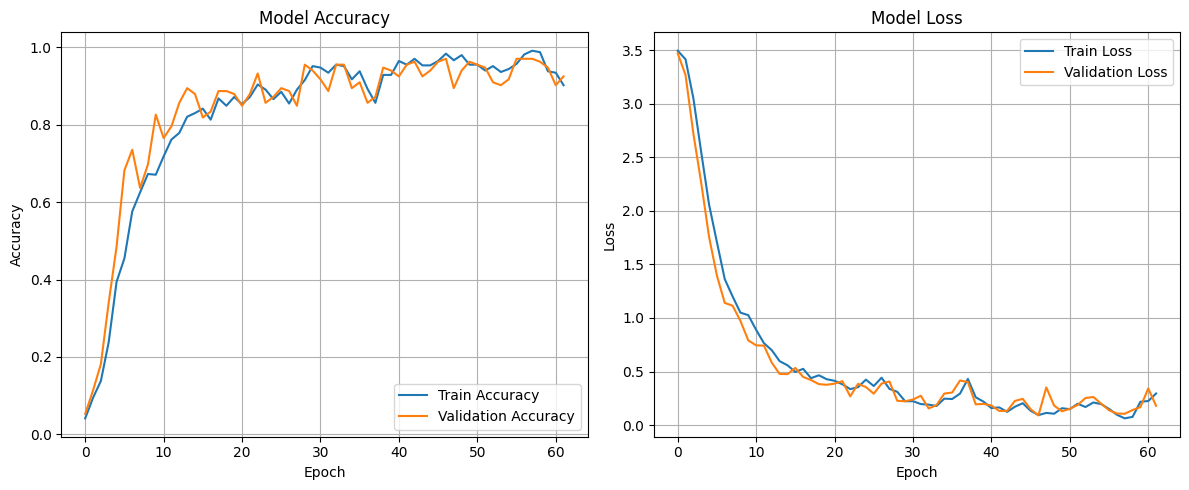


Saving label mapping to ./models/label_map_sequences.pickle
Label mapping saved.

Model training script finished.


In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

# --- Configuration ---
DATA_PICKLE_FILE = './train_data_set/asl_sequences_dataset.pickle'
MODEL_SAVE_DIR = './models'
BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'best_lstm_model_sequences.pth')
LABEL_MAP_PATH = os.path.join(MODEL_SAVE_DIR, 'label_map_sequences.pickle')
HISTORY_PLOT_PATH = os.path.join(MODEL_SAVE_DIR, 'training_history_lstm.png')

# Ensure model save directory exists
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# --- Device Setup (Enable GPU on Mac if available) ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# --- Load Data ---
print(f"Loading data from: {DATA_PICKLE_FILE}")
try:
    with open(DATA_PICKLE_FILE, 'rb') as f:
        data_dict = pickle.load(f)
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_PICKLE_FILE}. Please run the dataset creation script first.")
    exit()
except Exception as e:
    print(f"Error loading data file: {e}")
    exit()

# Extract data and labels
# Data should be list of sequences, each sequence is list of feature vectors
data = data_dict['data']
labels = np.asarray(data_dict['labels'])

print(f"Loaded {len(data)} samples.")
if not data:
    print("Error: No data loaded. Exiting.")
    exit()

# --- Data Preparation ---
# Convert data to numpy array (N, Sequence Length, Features)
try:
    # Assuming all sequences have the same length and feature dim from the creation script
    data_array = np.array(data, dtype=np.float32)
    print(f"Data array shape: {data_array.shape}") # Should be (num_samples, 30, 84)
except ValueError as e:
    print(f"Error converting data to NumPy array. Ensure all sequences have the same length (30) and feature dim (84): {e}")
    # Optional: Add padding/truncating here if lengths vary, but the creation script should handle this.
    exit()

# Convert labels to numeric
unique_labels = np.unique(labels)
label_map = {label: i for i, label in enumerate(unique_labels)}
numeric_labels = np.array([label_map[label] for label in labels])
reverse_label_map = {i: label for label, i in label_map.items()}
num_classes = len(unique_labels)
print(f"Number of classes: {num_classes}")
print(f"Label map created: {label_map}")

# Split data (Train/Validation/Test) - Using 80% train, 20% test for simplicity now
# For more robust evaluation, consider a separate validation set (e.g., 70/15/15 split)
x_train, x_test, y_train, y_test = train_test_split(
    data_array, numeric_labels, test_size=0.2, shuffle=True, stratify=numeric_labels, random_state=42
)
print(f"Train samples: {len(x_train)}, Test samples: {len(x_test)}")

# Convert to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.LongTensor(y_train)
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets and dataloaders
batch_size = 32 # Adjust as needed based on GPU memory
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- Define LSTM Model ---
class HandGestureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(HandGestureLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True means input tensor shape is (batch, seq_len, features)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        # Shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # We need to detach hidden states to prevent gradient flow back further than intended
        # if they were carried over from previous batches (not applicable here as we re-initialize)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0.detach(), c0.detach())) # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :]) # Get output of the last time step
        out = self.fc(out)
        return out

# --- Model Initialization ---
input_size = data_array.shape[2] # Should be 84
hidden_size = 128 # Can be tuned
num_layers = 2    # Can be tuned (e.g., 1 or 2 layers)
dropout_prob = 0.5 # Can be tuned

model = HandGestureLSTM(input_size, hidden_size, num_layers, num_classes, dropout_prob).to(device)
print("\nModel Architecture:")
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate can be tuned

# --- Training and Evaluation Functions ---
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_epoch(model, test_loader, criterion, device):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.inference_mode(): # Use inference_mode for efficiency
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

# --- Training Loop ---
epochs = 100 # Adjust as needed
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0
patience = 15 # Number of epochs to wait for improvement before stopping
counter = 0

print("\nStarting Training...")
start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_epoch(model, test_loader, criterion, device)

    epoch_duration = time.time() - epoch_start_time

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | '
          f'Duration: {epoch_duration:.2f}s')

    # Early stopping and saving best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        # Save best model state dictionary
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f'  Validation accuracy improved. Saved model to {BEST_MODEL_PATH}')
    else:
        counter += 1
        print(f'  Validation accuracy did not improve. Counter: {counter}/{patience}')
        if counter >= patience:
            print(f'  Early stopping triggered at epoch {epoch+1}. Best Val Acc: {best_val_acc:.4f}')
            break

training_duration = time.time() - start_time
print(f"\nTraining finished in {training_duration:.2f} seconds.")

# --- Final Evaluation ---
print(f"\nLoading best model from {BEST_MODEL_PATH} for final evaluation...")
try:
    # Load the best performing model state
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device)) # Ensure loading to correct device
    model.to(device) # Redundant if already on device, but safe

    final_test_loss, final_test_acc = evaluate_epoch(model, test_loader, criterion, device)
    print(f'Final Test Accuracy (Best Model): {final_test_acc:.4f}')
    print(f'Final Test Loss (Best Model): {final_test_loss:.4f}')
except FileNotFoundError:
    print(f"Error: Best model file not found at {BEST_MODEL_PATH}. Cannot perform final evaluation.")
except Exception as e:
     print(f"Error loading best model or evaluating: {e}")


# --- Plot Training History ---
print(f"\nSaving training history plot to {HISTORY_PLOT_PATH}")
try:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show() # Uncomment to display plot immediately if running interactively
except Exception as e:
    print(f"Error generating or saving plot: {e}")


# --- Save Label Mapping ---
print(f"\nSaving label mapping to {LABEL_MAP_PATH}")
try:
    with open(LABEL_MAP_PATH, 'wb') as f:
        pickle.dump({'label_map': label_map, 'reverse_label_map': reverse_label_map}, f)
    print("Label mapping saved.")
except Exception as e:
    print(f"Error saving label map: {e}")

print("\nModel training script finished.")
# ```
#

Try use Z dimension

In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os
import time # <-- Added missing import

# --- Configuration ---
# Use the output file from the updated dataset script
DATA_PICKLE_FILE = './train_data_set/asl_sequences_dataset_3D.pickle'
MODEL_SAVE_DIR = './models'
BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'best_lstm_model_sequences_3D.pth')
LABEL_MAP_PATH = os.path.join(MODEL_SAVE_DIR, 'label_map_sequences.pickle')
HISTORY_PLOT_PATH = os.path.join(MODEL_SAVE_DIR, 'training_history_lstm.png')

# Ensure model save directory exists
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# --- Device Setup (Enable GPU if available) ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# --- Load Data ---
print(f"Loading data from: {DATA_PICKLE_FILE}")
try:
    with open(DATA_PICKLE_FILE, 'rb') as f:
        data_dict = pickle.load(f)
except FileNotFoundError:
    print(f"Error: Data file not found at {DATA_PICKLE_FILE}. Please run the dataset creation script first.")
    exit()
except Exception as e:
    print(f"Error loading data file: {e}")
    exit()

# Extract data and labels (Data should be NumPy arrays from the new script)
data = data_dict['data'] # Should be numpy array (N, seq_len, features)
labels = data_dict['labels'] # Should be numpy array (N,)

print(f"Loaded {len(data)} samples.")
if len(data) == 0:
    print("Error: No data loaded. Exiting.")
    exit()

# --- Data Preparation ---
# Data is already a NumPy array from the new dataset script
data_array = data.astype(np.float32) # Ensure correct dtype
labels_array = np.asarray(labels) # Ensure labels are numpy array

print(f"Data array shape: {data_array.shape}") # Should be (num_samples, SEQUENCE_LENGTH, input_size) <-- Updated comment
# Example: (num_samples, 10, 84) or (num_samples, 10, 126)

# Convert labels to numeric
unique_labels, counts = np.unique(labels_array, return_counts=True)
label_map = {label: i for i, label in enumerate(unique_labels)}
numeric_labels = np.array([label_map[label] for label in labels_array])
reverse_label_map = {i: label for label, i in label_map.items()}
num_classes = len(unique_labels)
print(f"Number of classes: {num_classes}")
print("Class distribution:")
for label, count in zip(unique_labels, counts):
    print(f"  - {label}: {count}")
# print(f"Label map created: {label_map}") # Optional: print if needed

# Split data (Train/Validation)
# Using 'test' set as validation during training for simplicity.
# For rigorous results, consider a separate test set.
x_train, x_val, y_train, y_val = train_test_split(
    data_array, numeric_labels, test_size=0.2, shuffle=True, stratify=numeric_labels, random_state=42
)
print(f"Train samples: {len(x_train)}, Validation samples: {len(x_val)}")

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 32 # Adjust as needed based on GPU memory
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor) # Use validation set here

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True) # Renamed to val_loader

# --- Define LSTM Model ---
class HandGestureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(HandGestureLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True means input tensor shape is (batch, seq_len, features)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0,
                            bidirectional=False) # Can experiment with bidirectional=True
        # If bidirectional=True, self.fc input size needs to be hidden_size * 2
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes) # Adjust if bidirectional

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        # Shape: (num_layers * num_directions, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Adjust num_layers * 2 if bidirectional
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Adjust num_layers * 2 if bidirectional

        # Forward propagate LSTM
        # out contains outputs for every time step
        # hn is the hidden state for the last time step
        # cn is the cell state for the last time step
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Decode the hidden state of the last time step
        # out: (batch_size, seq_length, hidden_size * num_directions)
        # We use the output of the last time step: out[:, -1, :]
        # Shape: (batch_size, hidden_size * num_directions)
        last_time_step_out = out[:, -1, :]

        # Apply dropout and final linear layer
        out = self.dropout(last_time_step_out)
        out = self.fc(out)
        return out

# --- Model Initialization ---
input_size = data_array.shape[2] # Dynamically determined (e.g., 84 or 126)
hidden_size = 128 # Can be tuned
num_layers = 2    # Can be tuned (e.g., 1 or 2 layers)
dropout_prob = 0.5 # Can be tuned

model = HandGestureLSTM(input_size, hidden_size, num_layers, num_classes, dropout_prob).to(device)
print("\nModel Architecture:")
print(model)
print(f"Input size: {input_size}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate can be tuned
# Consider using a learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# --- Training and Evaluation Functions ---
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True) # Use non_blocking with pin_memory

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        # Optional: Gradient clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_epoch(model, val_loader, criterion, device): # Changed loader name
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.inference_mode(): # Use inference_mode for efficiency
        for inputs, targets in val_loader: # Changed loader name
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

# --- Training Loop ---
epochs = 100 # Adjust as needed
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0
patience = 15 # Number of epochs to wait for improvement before stopping
counter = 0

print("\n--- Starting Training ---")
start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_epoch(model, val_loader, criterion, device) # Use val_loader

    epoch_duration = time.time() - epoch_start_time

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | '
          f'Duration: {epoch_duration:.2f}s')

    # Optional: Adjust learning rate with scheduler
    # scheduler.step(val_loss)

    # Early stopping and saving best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        # Save best model state dictionary
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f'  Validation accuracy improved to {best_val_acc:.4f}. Saved model to {BEST_MODEL_PATH}')
    else:
        counter += 1
        # print(f'  Validation accuracy did not improve. Counter: {counter}/{patience}') # Optional: less verbose
        if counter >= patience:
            print(f'  Early stopping triggered at epoch {epoch+1}. Best Val Acc: {best_val_acc:.4f}')
            break

training_duration = time.time() - start_time
print(f"\n--- Training finished in {training_duration:.2f} seconds ---")

# --- Final Evaluation on Validation Set (using the best model) ---
print(f"\nLoading best model from {BEST_MODEL_PATH} for final evaluation on validation set...")
try:
    # Load the best performing model state
    # Create a new instance or load into the existing model
    # Ensure the model definition matches the saved state_dict
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
    model.to(device) # Ensure model is on the correct device

    final_val_loss, final_val_acc = evaluate_epoch(model, val_loader, criterion, device)
    print(f'Final Validation Accuracy (Best Model): {final_val_acc:.4f}')
    print(f'Final Validation Loss (Best Model): {final_val_loss:.4f}')
except FileNotFoundError:
    print(f"Error: Best model file not found at {BEST_MODEL_PATH}. Cannot perform final evaluation.")
except Exception as e:
     print(f"Error loading best model or evaluating: {e}")


# --- Plot Training History ---
print(f"\nSaving training history plot to {HISTORY_PLOT_PATH}")
try:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    # Only plot up to the point where training stopped
    epochs_ran = len(train_accs)
    plt.plot(range(1, epochs_ran + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, epochs_ran + 1), val_accs, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_ran + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(HISTORY_PLOT_PATH) # Save the plot
    print(f"Plot saved to {HISTORY_PLOT_PATH}")
    # plt.show() # Uncomment to display plot immediately if running interactively
    plt.close() # Close the plot figure to free memory
except Exception as e:
    print(f"Error generating or saving plot: {e}")


# --- Save Label Mapping ---
print(f"\nSaving label mapping to {LABEL_MAP_PATH}")
try:
    with open(LABEL_MAP_PATH, 'wb') as f:
        pickle.dump({'label_map': label_map, 'reverse_label_map': reverse_label_map}, f)
    print("Label mapping saved.")
except Exception as e:
    print(f"Error saving label map: {e}")

print("\n--- Model training script finished ---")


Using MPS (Apple Silicon GPU)
Loading data from: ./train_data_set/asl_sequences_dataset_sorted_1.pickle
Loaded 660 samples.
Data array shape: (660, 10, 126)
Number of classes: 33
Class distribution:
  - A: 20
  - B: 20
  - C: 20
  - D: 20
  - E: 20
  - Engineer: 20
  - F: 20
  - G: 20
  - H: 20
  - Hello: 20
  - I: 20
  - J: 20
  - K: 20
  - L: 20
  - M: 20
  - Me: 20
  - My: 20
  - N: 20
  - Name: 20
  - No: 20
  - O: 20
  - P: 20
  - Q: 20
  - R: 20
  - S: 20
  - T: 20
  - U: 20
  - V: 20
  - W: 20
  - X: 20
  - Y: 20
  - Yes: 20
  - Z: 20
Train samples: 528, Validation samples: 132

Model Architecture:
HandGestureLSTM(
  (lstm): LSTM(126, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=33, bias=True)
)
Input size: 126

--- Starting Training ---


/Users/hoangnamtran/Desktop/Code/AI/ASL_Classification/venv311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/100 | Train Loss: 3.4988 | Train Acc: 0.0417 | Val Loss: 3.4677 | Val Acc: 0.0985 | Duration: 2.10s
  Validation accuracy improved to 0.0985. Saved model to ./models/best_lstm_model_sequences_sorted_1.pth
Epoch 2/100 | Train Loss: 3.4046 | Train Acc: 0.0814 | Val Loss: 3.2725 | Val Acc: 0.1515 | Duration: 1.76s
  Validation accuracy improved to 0.1515. Saved model to ./models/best_lstm_model_sequences_sorted_1.pth
Epoch 3/100 | Train Loss: 3.0515 | Train Acc: 0.1648 | Val Loss: 2.7048 | Val Acc: 0.1818 | Duration: 1.73s
  Validation accuracy improved to 0.1818. Saved model to ./models/best_lstm_model_sequences_sorted_1.pth
Epoch 4/100 | Train Loss: 2.4508 | Train Acc: 0.2879 | Val Loss: 2.2544 | Val Acc: 0.3485 | Duration: 1.83s
  Validation accuracy improved to 0.3485. Saved model to ./models/best_lstm_model_sequences_sorted_1.pth
Epoch 5/100 | Train Loss: 2.0223 | Train Acc: 0.3750 | Val Loss: 1.7121 | Val Acc: 0.4697 | Duration: 1.76s
  Validation accuracy improved to 0.4697

<h2> 4. Live Test

In [ ]:
import pickle
import cv2
import mediapipe as mp
import numpy as np
import torch
import torch.nn as nn
from collections import deque
import time # For FPS calculation
import os # Added for path joining

# --- Configuration ---
MODEL_SAVE_DIR = './models'
BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'best_lstm_model_sequences_sorted.pth')
LABEL_MAP_PATH = os.path.join(MODEL_SAVE_DIR, 'label_map_sequences.pickle')

SEQUENCE_LENGTH = 10          # Must match the training sequence length
NUM_LANDMARKS = 21
FEATURES_PER_LANDMARK = 2
FEATURES_PER_HAND = NUM_LANDMARKS * FEATURES_PER_LANDMARK # 42
TARGET_FEATURES_PER_FRAME = FEATURES_PER_HAND * 2         # 84 (for two hands, padded)
PREDICTION_THRESHOLD = 0.6   # Minimum confidence to display prediction

# --- Define LSTM Model Class (Must match training architecture) ---
class HandGestureLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(HandGestureLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        # Get output of the last time step and apply dropout
        out = self.dropout(out[:, -1, :])
        # Pass through final fully connected layer
        out = self.fc(out)
        return out

# --- Device Setup ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# --- Load Label Mapping ---
print(f"Loading label mapping from: {LABEL_MAP_PATH}")
try:
    with open(LABEL_MAP_PATH, 'rb') as f:
        label_info = pickle.load(f)
        label_map = label_info['label_map']
        reverse_label_map = label_info['reverse_label_map']
        num_classes = len(label_map)
        print(f"Loaded {num_classes} classes.")
except FileNotFoundError:
    print(f"Error: Label map file not found at {LABEL_MAP_PATH}.")
    exit()
except Exception as e:
    print(f"Error loading label map file: {e}")
    exit()

# --- Load Model ---
print(f"Loading model from: {BEST_MODEL_PATH}")
# Determine model parameters (these should ideally be saved with the model or known)
input_size = TARGET_FEATURES_PER_FRAME # 84
hidden_size = 128 # Must match the hidden_size used during training
num_layers = 2    # Must match the num_layers used during training
dropout_prob = 0.5 # Must match dropout used during training

model = HandGestureLSTM(input_size, hidden_size, num_layers, num_classes, dropout_prob)
try:
    # Load the state dictionary onto the specified device
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
    model.to(device) # Ensure model is on the correct device
    model.eval() # Set model to evaluation mode
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {BEST_MODEL_PATH}.")
    exit()
except Exception as e:
    print(f"Error loading model state dictionary: {e}")
    exit()


# --- MediaPipe Initialization ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2, # Detect up to two hands
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# --- Helper Function for Normalization ---
def normalize_landmarks(landmarks, image_shape):
    """Normalizes landmarks relative to the hand's bounding box."""
    if not landmarks: return None
    # Get pixel coordinates first to calculate bounding box correctly
    x_coords_px = [lm.x * image_shape[1] for lm in landmarks.landmark]
    y_coords_px = [lm.y * image_shape[0] for lm in landmarks.landmark]
    if not x_coords_px or not y_coords_px: return None

    x_min_px, x_max_px = min(x_coords_px), max(x_coords_px)
    y_min_px, y_max_px = min(y_coords_px), max(y_coords_px)

    # Calculate width and height for normalization denominator
    box_width = x_max_px - x_min_px
    box_height = y_max_px - y_min_px

    # Avoid division by zero for degenerate bounding boxes
    if box_width == 0 or box_height == 0: return None

    normalized_features = []
    for lm in landmarks.landmark:
        # Normalize relative to the bounding box dimensions
        norm_x = (lm.x * image_shape[1] - x_min_px) / box_width
        norm_y = (lm.y * image_shape[0] - y_min_px) / box_height
        normalized_features.extend([norm_x, norm_y])

    # Ensure correct feature count
    return normalized_features if len(normalized_features) == FEATURES_PER_HAND else None

# --- Live Test Initialization ---
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

sequence_buffer = deque(maxlen=SEQUENCE_LENGTH) # Buffer to hold the last N frames' features
current_prediction = ""
current_confidence = 0.0

# For FPS calculation
frame_count = 0
start_time = time.time()

print("\nStarting Live Recognition...")
print("Press 'Q' or 'Esc' to exit.")

# Define window name
WINDOW_NAME = 'ASL Live Recognition (LSTM)'

while True:
    # --- Frame Capture and FPS ---
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture frame.")
        break

    frame_count += 1
    elapsed_time = time.time() - start_time
    fps = frame_count / elapsed_time if elapsed_time > 0 else 0

    H, W, _ = frame.shape
    display_frame = frame.copy() # Work on a copy for drawing

    # --- MediaPipe Processing ---
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_rgb.flags.writeable = False # Optimize
    results = hands.process(image_rgb)
    image_rgb.flags.writeable = True

    # --- Landmark Extraction and Feature Creation ---
    frame_features = np.zeros(TARGET_FEATURES_PER_FRAME, dtype=np.float32) # Start with zeros (padding)
    detected_hands_landmarks = [] # Store raw landmarks for drawing bounding boxes later

    if results.multi_hand_landmarks:
        normalized_hands_features = []

        for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            if hand_idx >= 2: break # Process max 2 hands

            # Draw landmarks on the display frame
            mp_drawing.draw_landmarks(
                display_frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())

            # Normalize features for this hand
            norm_features = normalize_landmarks(hand_landmarks, frame.shape)
            if norm_features:
                normalized_hands_features.append(norm_features)
                # Store raw landmarks for bounding box calculation later
                detected_hands_landmarks.append(hand_landmarks) # Store landmarks object

        # Assign features (handle 1 vs 2 hands)
        if len(normalized_hands_features) == 1:
            frame_features[:FEATURES_PER_HAND] = normalized_hands_features[0]
        elif len(normalized_hands_features) == 2:
            # Simple assignment: first detected -> first slot, second -> second slot
            frame_features[:FEATURES_PER_HAND] = normalized_hands_features[0]
            frame_features[FEATURES_PER_HAND:] = normalized_hands_features[1]

    # --- Sequence Management and Prediction ---
    sequence_buffer.append(frame_features)

    # Only predict if the buffer is full
    if len(sequence_buffer) == SEQUENCE_LENGTH:
        try:
            # Prepare input tensor for LSTM: (1, seq_len, features)
            input_sequence = np.array(list(sequence_buffer), dtype=np.float32)
            input_tensor = torch.FloatTensor(input_sequence).unsqueeze(0).to(device) # Add batch dimension

            # Make prediction
            with torch.inference_mode(): # Use inference mode
                outputs = model(input_tensor)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                confidence, predicted_idx = torch.max(probabilities, 1)

                pred_idx = predicted_idx.item()
                conf_val = confidence.item()

                # Update current prediction if confidence is high enough
                if conf_val >= PREDICTION_THRESHOLD:
                    # Check if the prediction index is valid
                    if pred_idx in reverse_label_map:
                        current_prediction = reverse_label_map[pred_idx]
                        current_confidence = conf_val
                    else:
                        print(f"Warning: Predicted index {pred_idx} not in reverse_label_map.")
                        current_prediction = "Unknown"
                        current_confidence = conf_val # Still show confidence
                else:
                    # Confidence below threshold, clear prediction
                    current_prediction = ""
                    current_confidence = 0.0

        except Exception as e:
            print(f"Prediction error: {e}")
            current_prediction = "Error"
            current_confidence = 0.0

    # --- Drawing Bounding Boxes and Predictions ---
    # Draw bounding boxes for detected hands
    for hand_landmarks in detected_hands_landmarks:
         # Calculate bounding box from the landmarks object
         x_coords = [lm.x for lm in hand_landmarks.landmark]
         y_coords = [lm.y for lm in hand_landmarks.landmark]
         if x_coords and y_coords:
             x_min, x_max = min(x_coords), max(x_coords)
             y_min, y_max = min(y_coords), max(y_coords)
             # Convert relative coords to pixel coords
             x1 = max(0, int(x_min * W) - 10)
             y1 = max(0, int(y_min * H) - 10)
             x2 = min(W, int(x_max * W) + 10)
             y2 = min(H, int(y_max * H) + 10)
             cv2.rectangle(display_frame, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green box

    # Display FPS
    cv2.putText(display_frame, f"FPS: {fps:.1f}", (W - 100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)

    # Display Prediction Status
    pred_text = f"Prediction: {current_prediction} ({current_confidence:.2f})" if current_prediction else "Prediction: ..."
    cv2.putText(display_frame, pred_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2, cv2.LINE_AA)

    # Display Buffer Status
    buffer_status = f"Buffer: {len(sequence_buffer)}/{SEQUENCE_LENGTH}"
    cv2.putText(display_frame, buffer_status, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2, cv2.LINE_AA)


    # --- Display Frame ---
    cv2.imshow(WINDOW_NAME, display_frame)

    # --- Exit Condition ---
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') or key == 27: # 27 is Escape key
        break

# --- Cleanup ---
print("\nExiting...")
cap.release()
# Explicitly destroy the named window
try:
    cv2.destroyWindow(WINDOW_NAME)
except cv2.error:
    # Window might have been closed manually or never opened properly
    pass
# Close all other potential OpenCV windows
cv2.destroyAllWindows()
# Ensure any remaining GUI events are processed (optional, can help on some systems)
for i in range(5):
    cv2.waitKey(1)
# Release MediaPipe hands resources
hands.close()
print("Resources released.")


Using MPS (Apple Silicon GPU)
Loading label mapping from: ./models_padded/label_map_padded.pickle
Loaded 33 classes.
Loading model from: ./models_padded/best_lstm_model_padded.pth
Model loaded successfully.


I0000 00:00:1746336262.732085 27857068 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1746336262.742397 28462300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746336262.751878 28462300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



Starting Live Recognition...
Press 'Q' or 'Esc' to exit.

Exiting...
Resources released.


Using MPS (Apple Silicon GPU)
Loading label mapping from: ./models/label_map_sequences.pickle
Loaded 33 classes.
Loading model from: ./models/best_lstm_model_sequences.pth
Model loaded successfully.


I0000 00:00:1746308807.141943 27857068 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1746308807.146317 27862883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1746308807.150444 27862883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



--- Starting Live Recognition ---
------------------------------------
Added: Hello | Sentence: Hello
Added: [SPACE]
Added: My | Sentence: Hello My
Added: [SPACE]
Added: Name | Sentence: Hello My Name
Added: [SPACE]
Added: N | Sentence: Hello My Name N
Added: A | Sentence: Hello My Name NA
Added: M | Sentence: Hello My Name NAM
Added: [SPACE]

Sending to API: 'Hello My Name NAM'
DUMMY API: Analyzing 'Hello My Name NAM'
API Response: Meaning: NAM Name My Hello

Exiting...
Resources released.
